In [34]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import keras_tuner as kt


data = tf.keras.utils.get_file(
    "tf_flowers", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True
)
data_dir = os.path.join(os.path.dirname(data), 'flower_photos')

batch_size = 32
img_height = 180
img_width = 180

# 데이터 분할
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)



# 정규화
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# 데이터와 레이블 맵핑
X_train = []
y_train = []
for images, labels in train_ds:
    X_train.append(images)
    y_train.append(labels)
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train, axis=0)

X_val = []
y_val = []
for images, labels in val_ds:
    X_val.append(images)
    y_val.append(labels)
X_val = tf.concat(X_val, axis=0)
y_val = tf.concat(y_val, axis=0)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)

228827136/228813984 [==============================] - 1s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [36]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)

        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

In [37]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(img_height, img_width, 3), name='inputs'))

    for i in range(hp.Int('num_conv_blocks', min_value=1, max_value=5)):
        filters = hp.Int('filters_{i}'.format(i=i), min_value=32, max_value=128, step=32)
        for _ in range(hp.Int('num_conv_layers', min_value=1, max_value=3)):
            model.add(tf.keras.layers.Conv2D(filters, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())

    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):
        units = hp.Int('units_{i}'.format(i=i), min_value=32, max_value=256, step=32)
        model.add(tf.keras.layers.Dense(units, activation='relu'))

    model.add(tf.keras.layers.Dense(5, activation='softmax', name='outputs'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [38]:

my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

In [39]:
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()


Trial 10 Complete [00h 00m 11s]
accuracy: 0.5681198835372925

Best accuracy So Far: 0.6307901740074158
Total elapsed time: 00h 05m 56s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 41, 41, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 25600)           

In [42]:
model.fit(X_train, y_train, batch_size=32, epochs = 20)



Epoch 1/20
92/92 [==============================] - 3s 28ms/step - loss: 0.2921 - accuracy: 0.9002
Epoch 2/20
92/92 [==============================] - 3s 28ms/step - loss: 0.2277 - accuracy: 0.9237
Epoch 3/20
92/92 [==============================] - 3s 28ms/step - loss: 0.1122 - accuracy: 0.9629
Epoch 4/20
92/92 [==============================] - 3s 29ms/step - loss: 0.0496 - accuracy: 0.9830
Epoch 5/20
92/92 [==============================] - 3s 29ms/step - loss: 0.0643 - accuracy: 0.9823
Epoch 6/20
92/92 [==============================] - 3s 29ms/step - loss: 0.0284 - accuracy: 0.9925
Epoch 7/20
92/92 [==============================] - 3s 29ms/step - loss: 0.0236 - accuracy: 0.9928
Epoch 8/20
92/92 [==============================] - 3s 28ms/step - loss: 0.0393 - accuracy: 0.9881
Epoch 9/20
92/92 [==============================] - 3s 28ms/step - loss: 0.0645 - accuracy: 0.9840
Epoch 10/20
92/92 [==============================] - 3s 28ms/step - loss: 0.0146 - accuracy: 0.9986
Epoch 11/

NameError: name 'X_test' is not defined

In [43]:
evaluation_result = model.evaluate(X_val, y_val)

23/23 [==============================] - 0s 13ms/step - loss: 2.5603 - accuracy: 0.6458


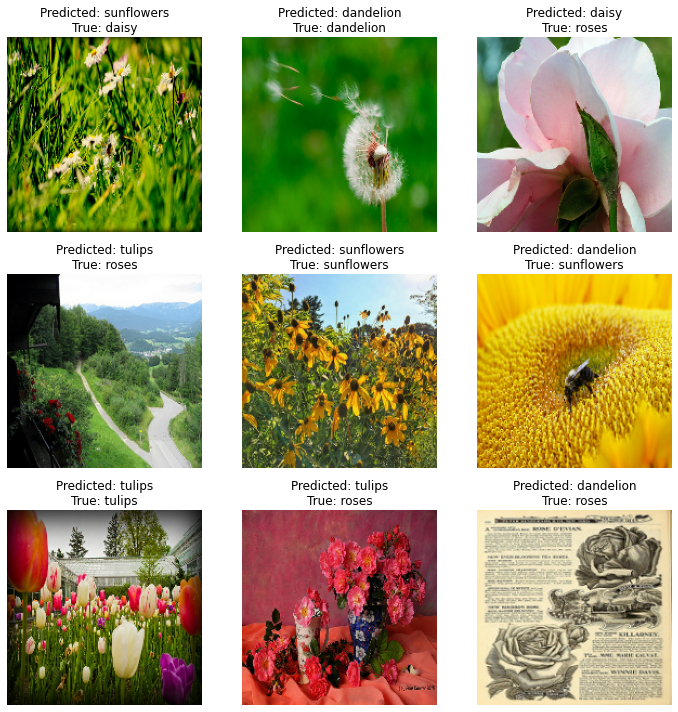

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 예측결과 시각화
y_pred = model.predict(X_val)
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_val, axis=1)

class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


plt.figure(figsize=(10, 10))
for i in range(9):
    index = np.random.randint(0, len(predicted_classes))
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_val[index])
    plt.title(f"Predicted: {class_names[predicted_classes[index]]}\nTrue: {class_names[true_classes[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [45]:
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/1/model/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/1/model/assets


In [ ]:
load_path = os.getenv('HOME') + '/aiffel/mlops/best_model/model'
best_model = tf.keras.models.load_model(load_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite